In [1]:
import gzip
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:

fontsize = 18
def hist2d_with_prob(x, y, x_hit, y_hit, W=None, W_hit=None, fontsize=12):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
    fig.tight_layout()
    
    # Define common histogram parameters
    bins = 50
    
    # First histogram (All data)
    h1, xedges, yedges, im1 = axes[0].hist2d(x, y, bins=bins,  
                                             cmap='viridis', norm=LogNorm(), density=False, weights=W)
    axes[0].set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
    axes[0].set_ylabel('$P_t$ [GeV]', fontsize=fontsize)
    axes[0].set_title('Input Sample', fontsize=fontsize)
    cbar1 = fig.colorbar(im1, ax=axes[0], label='Counts')
    
    # Second histogram (Hit=1 data)
    h2, _, _, im2 = axes[1].hist2d(x_hit, y_hit, bins=[xedges, yedges], 
                                   cmap='viridis', norm=LogNorm(), density=False, weights=W_hit)
    axes[1].set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
    axes[1].set_title('Input momentum that hit T1', fontsize=fontsize)
    cbar2 = fig.colorbar(im2, ax=axes[1], label='Counts')
    
    # Third histogram (Probability - normalized)
    # Calculate probability (avoid division by zero)
    h_prob = np.zeros_like(h1, dtype=float)
    mask = h1 > 0
    h_prob[mask] = h2[mask] / h1[mask]
    # Third histogram (Probability)
    # Create a masked array where 0 values are masked
    masked_h_prob = np.ma.masked_where(h_prob == 0, h_prob)
    
    # Create a colormap with white for masked values
    cmap = plt.cm.viridis.copy()
    cmap.set_bad('white')
    
    # Check if there are any non-zero values to avoid LogNorm issues
    if np.any(h_prob > 0):
        # Find minimum non-zero value to use as vmin for LogNorm
        min_nonzero = np.min(h_prob[h_prob > 0])
        # Use pcolormesh with LogNorm for logarithmic scale
        im3 = axes[2].pcolormesh(xedges, yedges, masked_h_prob.T, cmap=cmap, 
                                norm=LogNorm(vmin=min_nonzero, vmax=1))
    else:
        # If all values are zero, use linear scale
        im3 = axes[2].pcolormesh(xedges, yedges, masked_h_prob.T, cmap=cmap, vmin=0, vmax=1)
    
    axes[2].set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
    axes[2].set_title('Hit Probability', fontsize=fontsize)
    cbar3 = fig.colorbar(im3, ax=axes[2], label='Probability')
    

    
    return h1, h2, h_prob, xedges, yedges


def average_probability_histograms(p, pt, hit_arrays, fontsize=14):
    """
    Average probability histograms from multiple models using the same p and pt values.
    
    Parameters:
    -----------
    p : numpy array
        Momentum values (same for all models)
    pt : numpy array
        Transverse momentum values (same for all models)
    hit_arrays : list of numpy arrays
        List of hit arrays (0/1) from different models, each with same shape as p and pt
    fontsize : int
        Font size for plot labels
        
    Returns:
    --------
    h_avg_prob : 2D numpy array
        The averaged probability histogram
    """
    # Check that we have at least one model
    n_models = len(hit_arrays)
    if n_models == 0:
        raise ValueError("No hit arrays provided")
    
    # Histogram parameters
    bins = 50
    p_range = (0, 10)
    pt_range = (0, 10)
    
    # Create an array to store all probability histograms
    all_probs = []
    
    # Calculate histograms for each model
    for i, hit in enumerate(hit_arrays):
        # Filter data for hit=1
        p_hit = p[hit == 1]
        pt_hit = pt[hit == 1]
        
        # Calculate histograms
        h_all, xedges, yedges = np.histogram2d(p, pt, bins=bins, range=[p_range, pt_range])
        h_hit, _, _ = np.histogram2d(p_hit, pt_hit, bins=[xedges, yedges])
        
        # Calculate probability histogram
        h_prob = np.zeros_like(h_all, dtype=float)
        mask = h_all > 0
        h_prob[mask] = h_hit[mask] / h_all[mask]
        
        # Store the probability histogram
        all_probs.append(h_prob)
        
        print(f"Model {i+1}/{n_models} processed - Hit rate: {np.mean(hit):.4f}")
    
    # Calculate the average probability histogram
    h_avg_prob = np.mean(all_probs, axis=0)
    
    # Create a figure to display the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot the averaged probability histogram
    im1 = ax1.pcolormesh(xedges, yedges, h_avg_prob.T, cmap='plasma', vmin=0, vmax=1)
    ax1.set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
    ax1.set_ylabel('$P_t$ [GeV]', fontsize=fontsize)
    ax1.set_title(f'Averaged Hit Probability (N={n_models})', fontsize=fontsize)
    fig.colorbar(im1, ax=ax1, label='Probability')
    
    # Plot the standard deviation of probabilities
    if n_models > 1:
        h_std_prob = np.std(all_probs, axis=0)
        im2 = ax2.pcolormesh(xedges, yedges, h_std_prob.T, cmap='viridis')
        ax2.set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
        ax2.set_ylabel('$P_t$ [GeV]', fontsize=fontsize)
        ax2.set_title('Standard Deviation of Hit Probabilities', fontsize=fontsize)
        fig.colorbar(im2, ax=ax2, label='Std Dev')
    
    # Adjust tick parameters
    for ax in [ax1, ax2]:
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    plt.tight_layout()
    plt.show()
    
    # Optional: Show a few individual probability histograms if there are at least 3 models
    if n_models >= 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
        
        for i, ax in enumerate(axes):
            if i < n_models:
                im = ax.pcolormesh(xedges, yedges, all_probs[i].T, cmap='plasma', vmin=0, vmax=1)
                ax.set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
                if i == 0:
                    ax.set_ylabel('$P_t$ [GeV]', fontsize=fontsize)
                ax.set_title(f'Model {i+1} Probability', fontsize=fontsize)
                fig.colorbar(im, ax=ax, label='Probability')
                ax.tick_params(axis='both', which='major', labelsize=fontsize)
        
        plt.tight_layout()
        plt.show()
    
    # Additionally, plot the difference between the highest and lowest probabilities for each bin
    if n_models > 1:
        h_max_prob = np.max(all_probs, axis=0)
        h_min_prob = np.min(all_probs, axis=0)
        h_range_prob = h_max_prob - h_min_prob
        
        plt.figure(figsize=(10, 8))
        im = plt.pcolormesh(xedges, yedges, h_range_prob.T, cmap='viridis')
        plt.xlabel('$|P|$ [GeV]', fontsize=fontsize)
        plt.ylabel('$P_t$ [GeV]', fontsize=fontsize)
        plt.title('Range of Probabilities Across Models', fontsize=fontsize)
        plt.colorbar(im, label='Probability Range')
        plt.tight_layout()
        plt.show()
    
    return h_avg_prob, xedges, yedges, all_probs

In [3]:
def extract_number_from_string(s):
    number_str = ''
    for char in s:
        if char.isdigit(): 
            number_str += char
    return int(number_str)

In [17]:
folder = "/home/hep/lprate/projects/MuonsAndMatter/data/outputs/baseline_no_cavern"
data = []
ns = []
for file_name in os.listdir(folder):
    print(file_name)
    data.append(np.load(os.path.join(folder,file_name)))
    ns.append(extract_number_from_string(file_name))
data = np.concatenate(data,axis=1).T


data_input = []
'''for file_name in os.listdir('../full_sample'):
    n_name = extract_number_from_string(file_name)
    if n_name not in ns: continue
    print(file_name)
    with gzip.open(f'../full_sample/{file_name}', 'rb') as f:
        data_input.append(pickle.load(f))'''
for n in ns:
    file_name = f'../full_sample/full_sample_{n}.pkl'
    print(file_name)
    with gzip.open(file_name, 'rb') as f:
        data_input.append(pickle.load(f))
assert len(data_input) == len(ns)
data_input = np.concatenate(data_input)
print(data_input.shape)

assert data.shape == data_input.shape

muonsdata_60000.npy
muonsdata_37000.npy
muonsdata_41000.npy
muonsdata_32000.npy
muonsdata_17000.npy
muonsdata_12000.npy
muonsdata_38000.npy
muonsdata_55000.npy
muonsdata_0.npy
muonsdata_25000.npy
muonsdata_39000.npy
muonsdata_6000.npy
muonsdata_57000.npy
muonsdata_48000.npy
muonsdata_44000.npy
../full_sample/full_sample_60000.pkl
../full_sample/full_sample_37000.pkl
../full_sample/full_sample_41000.pkl
../full_sample/full_sample_32000.pkl
../full_sample/full_sample_17000.pkl
../full_sample/full_sample_12000.pkl
../full_sample/full_sample_38000.pkl
../full_sample/full_sample_55000.pkl
../full_sample/full_sample_0.pkl
../full_sample/full_sample_25000.pkl
../full_sample/full_sample_39000.pkl
../full_sample/full_sample_6000.pkl
../full_sample/full_sample_57000.pkl
../full_sample/full_sample_48000.pkl
../full_sample/full_sample_44000.pkl
(116781960, 8)


In [18]:
px,py,pz,x,y,z,pdg,W = data.T
sens_plane = (np.abs(pdg)==13) & (np.abs(x)<2) & (np.abs(y)<3)
#hit = sens_plane.astype(float)
px, py, pz, x, y, z, pdg, W = px[sens_plane], py[sens_plane], pz[sens_plane], x[sens_plane], y[sens_plane], z[sens_plane], pdg[sens_plane], W[sens_plane]
pt = np.sqrt(px**2+py**2)
p = np.sqrt(px**2+py**2+pz**2)

px_input, py_input, pz_input, x_input, y_input, z_input, pdg_input, W_input = data_input.T
pt_input = np.sqrt(px_input**2 + py_input**2)
p_input = np.sqrt(px_input**2 + py_input**2 + pz_input**2)

In [19]:
def project(x,y,px,py,pz,dist):
    return x+px*dist/pz, y+py*dist/pz
x_projected, y_projected = project(x,y,px,py,pz,10)
mask_t4 = (x_projected>-2) & (x_projected<2) & (y_projected>-3) & (y_projected<3)
W_projected = W[mask_t4]
p_projected = p[mask_t4]

In [20]:
p_projected.shape

(1175,)

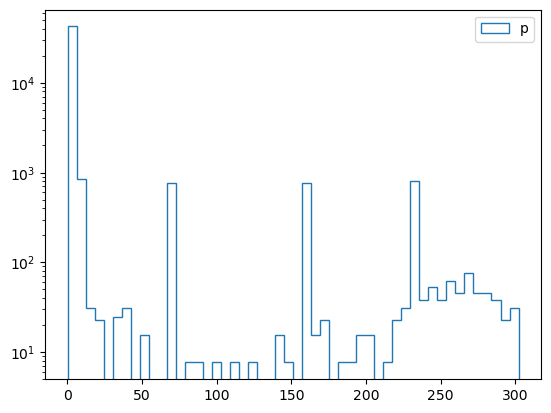

In [21]:
plt.hist(p_projected, bins=50, histtype='step', label='p', weights=W_projected, log=True)
#plt.hist(p_input[sens_plane], bins=50, histtype='step', label='p_input', weights=W_input[sens_plane], log=True)
plt.legend()
plt.show()

In [22]:
W_projected.sum()

46261.324

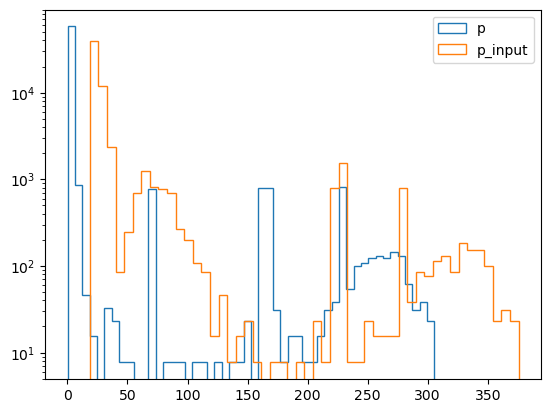

In [23]:
plt.hist(p, bins=50, histtype='step', label='p', weights=W, log=True)
plt.hist(p_input[sens_plane], bins=50, histtype='step', label='p_input', weights=W_input[sens_plane], log=True)
plt.legend()
plt.show()

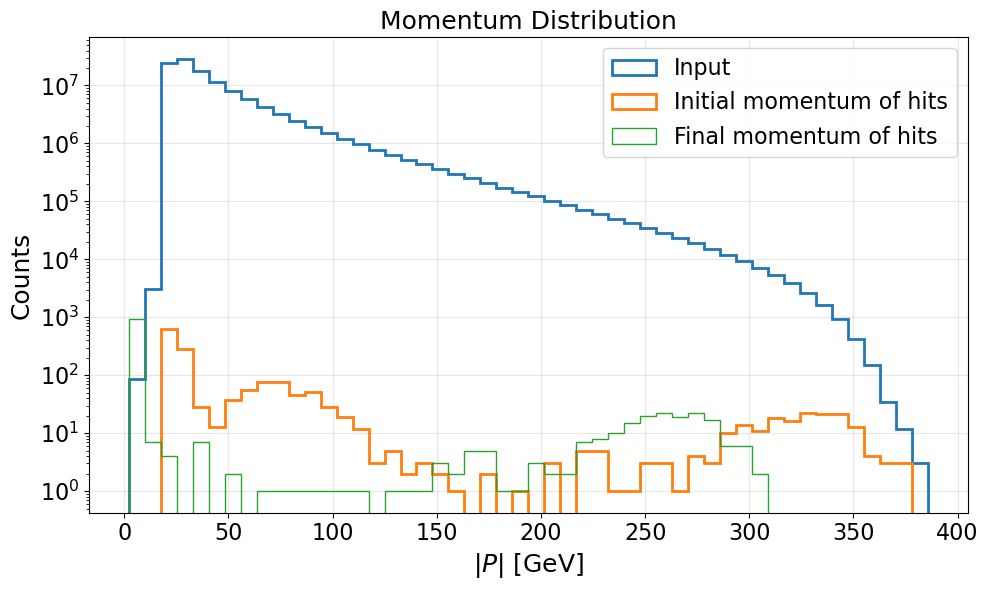

In [24]:
# Define figure with appropriate size
plt.figure(figsize=(10, 6))

# Create bins based on the range of p_input
bins = np.linspace(p_input.min(), p_input.max(), 50)

# Plot first histogram
n_p, bins, _ = plt.hist(p_input, bins=50, log=True, histtype='step', label='Input', linewidth=2)

# Plot second histogram with the same bins
n_h, _, _ = plt.hist(p_input[sens_plane], bins=bins, log=True, histtype='step', label='Initial momentum of hits', linewidth=2)

plt.hist(p, bins=bins, log=True, histtype='step', label='Final momentum of hits', linewidth=1)



# Add labels and title
plt.xlabel('$|P|$ [GeV]', fontsize=fontsize)
plt.ylabel('Counts', fontsize=fontsize)
plt.title('Momentum Distribution', fontsize=fontsize)
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=fontsize-2)

# Add legend
plt.legend(fontsize=fontsize-2)
plt.tight_layout()

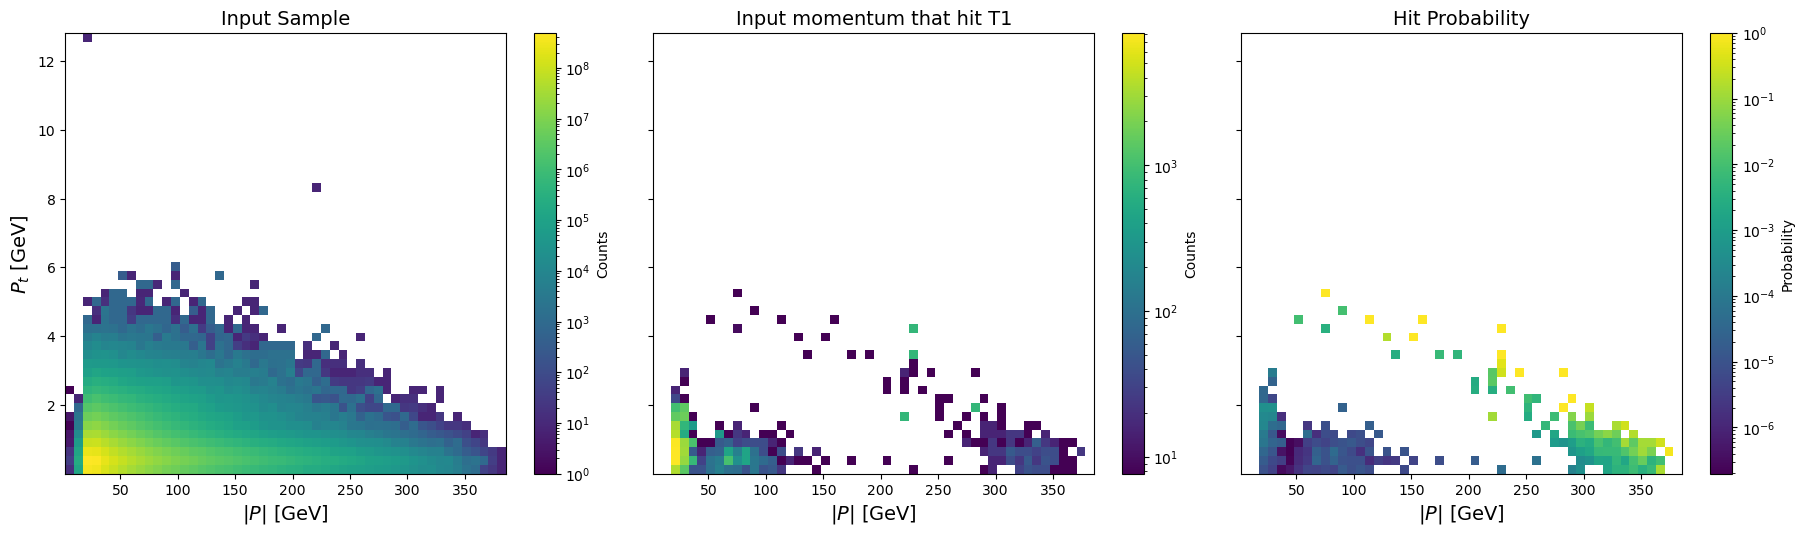

In [25]:
h_all, h_hit, h_prob, xedges, yedges = hist2d_with_prob(p_input, pt_input, p_input[sens_plane], pt_input[sens_plane], W_input, W_input[sens_plane], fontsize=14)


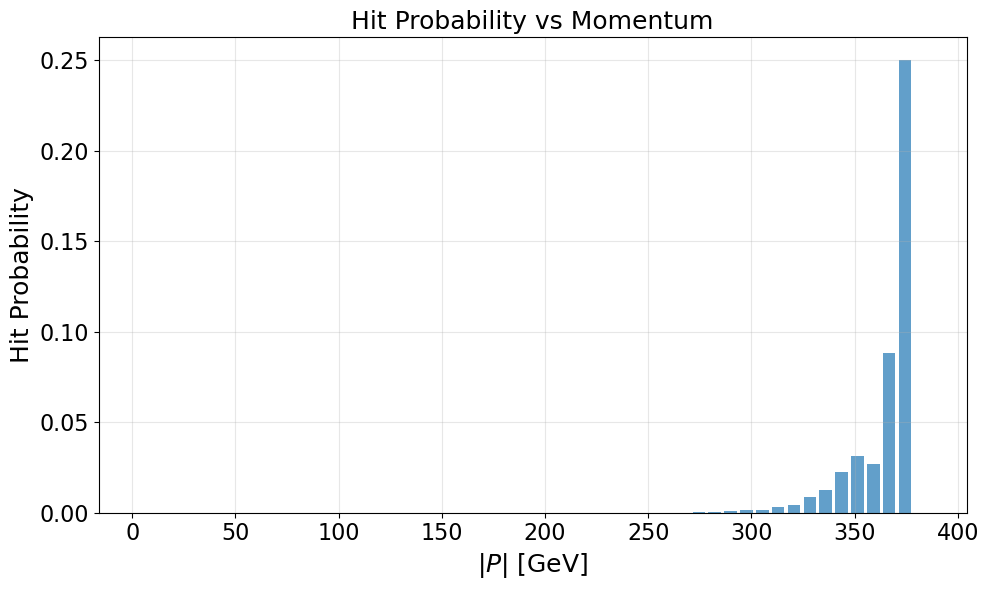

In [26]:
# Calculate bin centers for the ratio plot
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Create a second figure for the hit probability ratio
plt.figure(figsize=(10, 6))
ratio = np.zeros_like(n_p)
mask = n_p > 0
ratio[mask] = n_h[mask] / n_p[mask]

plt.bar(bin_centers, ratio, width=(bins[1]-bins[0])*0.8, alpha=0.7)
plt.xlabel('$|P|$ [GeV]', fontsize=fontsize)
plt.ylabel('Hit Probability', fontsize=fontsize)
plt.title('Hit Probability vs Momentum', fontsize=fontsize)
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=fontsize-2)
plt.tight_layout()

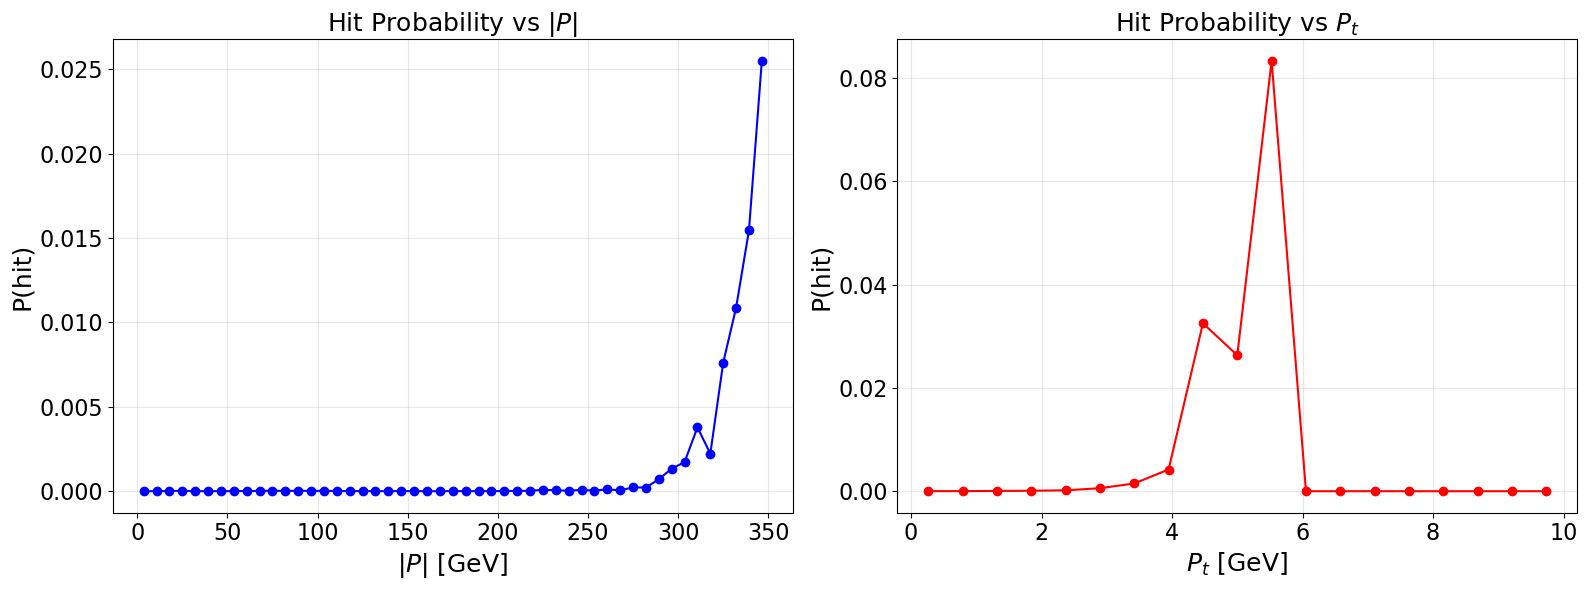

In [27]:
# Calculate hit probability as a function of p and pt separately
p_bins = np.linspace(0, 350, 50)
p_centers = 0.5 * (p_bins[1:] + p_bins[:-1])
p_hist_all, _ = np.histogram(p_input, bins=p_bins)
p_hist_hit, _ = np.histogram(p_input[sens_plane], bins=p_bins)
p_prob = np.zeros_like(p_hist_all, dtype=float)
mask = p_hist_all > 0
p_prob[mask] = p_hist_hit[mask] / p_hist_all[mask]

# Hit probability vs pt
pt_bins = np.linspace(0, 10, 20)
pt_centers = 0.5 * (pt_bins[1:] + pt_bins[:-1])
pt_hist_all, _ = np.histogram(pt_input, bins=pt_bins)
pt_hist_hit, _ = np.histogram(pt_input[sens_plane], bins=pt_bins)
pt_prob = np.zeros_like(pt_hist_all, dtype=float)
mask = pt_hist_all > 0
pt_prob[mask] = pt_hist_hit[mask] / pt_hist_all[mask]

# Create two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First plot: hit probability vs |P|
ax1.plot(p_centers, p_prob, 'o-', color='blue')
ax1.set_title('Hit Probability vs $|P|$', fontsize=fontsize)
ax1.set_xlabel('$|P|$ [GeV]', fontsize=fontsize)
ax1.set_ylabel('P(hit)', fontsize=fontsize)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=fontsize-2)

# Second plot: hit probability vs Pt
ax2.plot(pt_centers, pt_prob, 'o-', color='red')
ax2.set_title('Hit Probability vs $P_t$', fontsize=fontsize)
ax2.set_xlabel('$P_t$ [GeV]', fontsize=fontsize)
ax2.set_ylabel('P(hit)', fontsize=fontsize)
ax2.grid(True, alpha=0.3)
ax2.tick_params(labelsize=fontsize-2)

plt.tight_layout()
plt.show()
